Transaction level return prediction: Predict IsReturn for each invoice

Goal in Real Life Application: Proactively suggest alternatives so recall is more important since it's ok to suggest alternatives to more people but you do want to capture those that will most likely return and suggest alternatives 

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib
from joblib import load

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, auc
from imblearn.over_sampling import SMOTE #install imbalanced-learn
import shap
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

In [2]:
df = pd.read_csv('online_retail_cleaned.csv')
df.IsReturn.value_counts()

IsReturn
0    789533
1     16087
Name: count, dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805620 entries, 0 to 805619
Data columns (total 72 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Invoice                       805620 non-null  int64  
 1   StockCode                     805620 non-null  object 
 2   Description                   805620 non-null  object 
 3   Quantity                      805620 non-null  int64  
 4   InvoiceDate                   805620 non-null  object 
 5   Price                         805620 non-null  float64
 6   Customer ID                   805620 non-null  float64
 7   Country                       805620 non-null  object 
 8   IsReturn                      805620 non-null  int64  
 9   InvoiceHour                   805620 non-null  int64  
 10  Time_Afternoon                805620 non-null  int64  
 11  Time_Evening                  805620 non-null  int64  
 12  Time_Morning                  805620 non-nul

In [4]:
# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [6]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 49.08


The scale_pos_weight parameter tells XGBoost to penalize the majority class less and the minority class more, so the model takes returns (IsReturn == 1) more seriously.

Each return is treated as 49 times more important than a non-return.

In [7]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:15:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [8]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      0.64      0.78    157907
           1       0.05      0.89      0.09      3217

    accuracy                           0.64    161124
   macro avg       0.52      0.77      0.44    161124
weighted avg       0.98      0.64      0.77    161124

AUC-ROC: 0.8649933818459963
AUC-PR: 0.19012540330654304


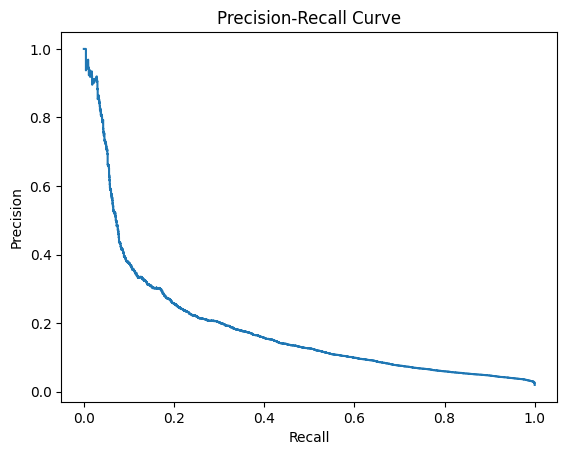

In [9]:
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

- Recall: Catching 89% of the actual returns
- Precision: Only 5% of the predictions labeled as “return” are actually returns - many false positives 
- F1: Balance between precision and recall is low - but that’s okay because your goal favors recall
- AUC-ROC: Your model ranks returnable transactions well above non-returnables — strong general modeling ability
- AUC-PR: Precision is low, especially when trying to keep recall high — expected when the positive class is super rare (~2%) but doing ~9× better than random, which is solid.

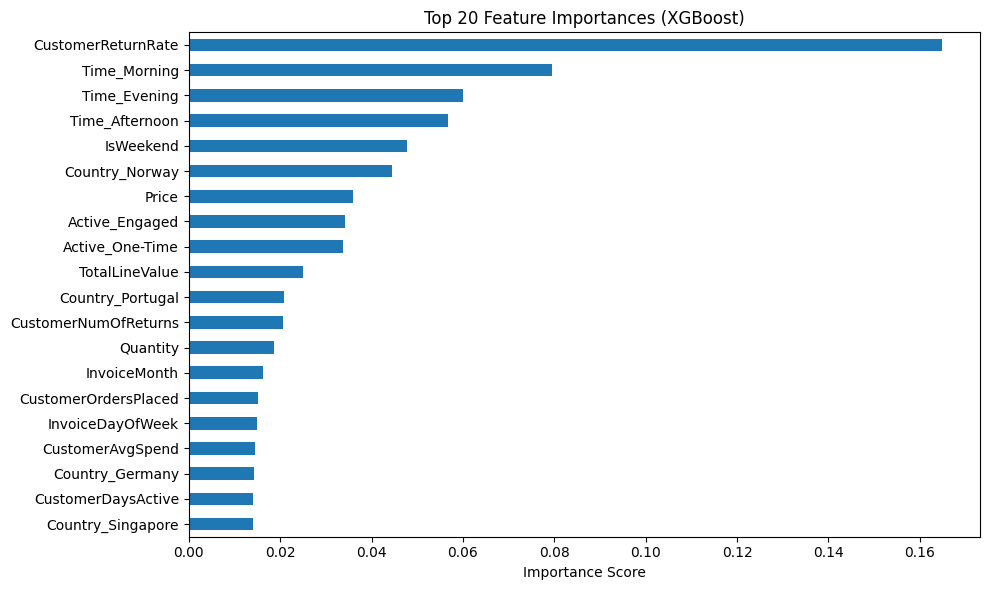

In [10]:
# Get feature importances (based on gain by default)
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Plot top features
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
# Save the model
joblib.dump(xgb_model, "xgb_1.pkl")
# Load it later
#loaded_model = joblib.load("xgb_1.pkl")

['xgb_1.pkl']

Don't use SMOTE only scale_pos_weight

In [22]:
def execute_model(xgb_model, id, scale_pos_weight):
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # Save the model
    joblib.dump(xgb_model, f"xgb_{id}.pkl")
    
    return xgb_model, y_pred, y_pred_proba

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.79      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.80      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8906045601549358
AUC-PR: 0.2504157997698522


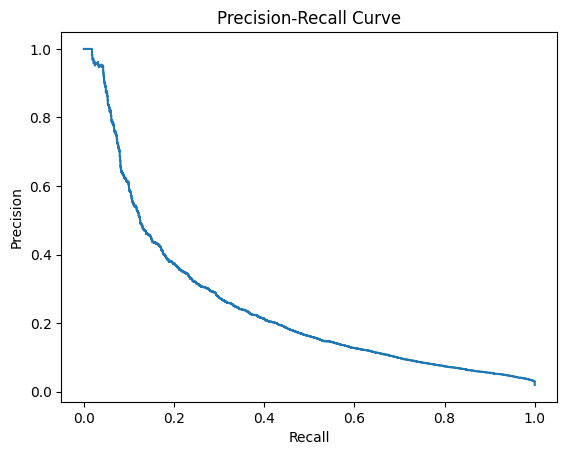

In [37]:
xgb_model_2, y_pred, y_pred_proba = execute_model(xgb_model,2, scale_pos_weight)

In [38]:
# Top 5% Precision
def precision_at_k(y_test, y_pred_custom, k_percent=0.05):
    df_preds = pd.DataFrame({
        'proba': y_pred_custom,         # predicted probabilities for class 1
        'actual': y_test               # true labels (0 or 1)
    })

    # Sort by predicted probability descending (most return-like first)
    df_preds = df_preds.sort_values(by='proba', ascending=False).reset_index(drop=True)

    # Define Top-K% (e.g., top 5%)
    K = int(len(df_preds) * k_percent)

    # Slice top K rows
    top_k = df_preds.iloc[:K]

    # Calculate Top-K Precision
    precision_at_k = top_k['actual'].sum() / K
    print(f"Top-{k_percent*100:.0f}% Precision: {precision_at_k:.4f}")
    return df_preds

Top-5% Precision: 0.1823


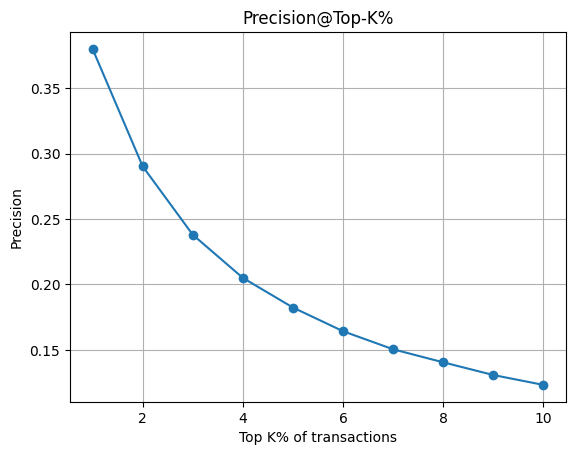

In [39]:
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

ks = np.arange(0.01, 0.11, 0.01)  # from 1% to 10%
precision_scores = []

for k in ks:
    K = int(len(df_preds) * k)
    top_k = df_preds.iloc[:K]
    precision = top_k['actual'].sum() / K
    precision_scores.append(precision)

plt.plot(ks * 100, precision_scores, marker='o')
plt.title("Precision@Top-K%")
plt.xlabel("Top K% of transactions")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

Among the top 5% most return-like transactions, 18% were actual returns, which is 9x better than your base return rate (~2%).

Add a threshold for probability predictions.

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid divide-by-zero

# Find the threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.886
Precision: 0.291, Recall: 0.291, F1: 0.291


In [41]:
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

In [42]:
print(classification_report(y_test, y_pred_custom))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    157907
           1       0.29      0.29      0.29      3217

    accuracy                           0.97    161124
   macro avg       0.64      0.64      0.64    161124
weighted avg       0.97      0.97      0.97    161124

AUC-ROC: 0.8906045601549358
AUC-PR: 0.2504157997698522


In [43]:
df_preds = precision_at_k(y_test, y_pred_custom, k_percent=0.05)

Top-5% Precision: 0.1252


F1 and precision are the highest of the other iterations. However, recall is significantly lower. 

Try a lower threshold like 0.40 for higher recall. Default is 0.50.

In [44]:
threshold = 0.4
y_pred_custom_50 = (y_pred_proba > threshold).astype(int)

def metric_result(y_pred_custom):
    print(classification_report(y_test, y_pred_custom))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

metric_result(y_pred_custom_50)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    157907
           1       0.06      0.86      0.12      3217

    accuracy                           0.74    161124
   macro avg       0.53      0.80      0.48    161124
weighted avg       0.98      0.74      0.83    161124

AUC-ROC: 0.8906045601549358
AUC-PR: 0.2504157997698522


In [45]:
df_preds = precision_at_k(y_test, y_pred_custom_50, k_percent=0.05)

Top-5% Precision: 0.0606


Model without scale_pos_weight for the imbalance.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    157907
           1       0.00      0.00      0.00      3217

    accuracy                           0.98    161124
   macro avg       0.49      0.50      0.49    161124
weighted avg       0.96      0.98      0.97    161124

AUC-ROC: 0.5
AUC-PR: 0.01996598892778233


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

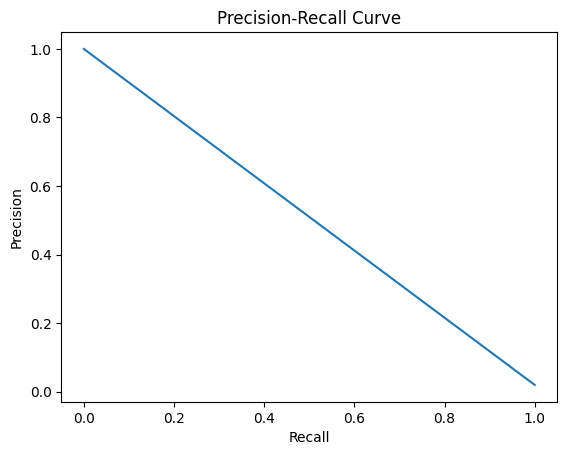

In [46]:
xgb_model_3, y_pred, y_pred_proba = execute_model(xgb_model,3, 0)

With no scale_pos_weight, the model is basically guessing randomly.

Try with just SMOTE for helping the imbalance.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:11:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.95      0.97    157907
           1       0.15      0.42      0.22      3217

    accuracy                           0.94    161124
   macro avg       0.57      0.68      0.60    161124
weighted avg       0.97      0.94      0.95    161124

AUC-ROC: 0.8704525028237002
AUC-PR: 0.2041490121453831


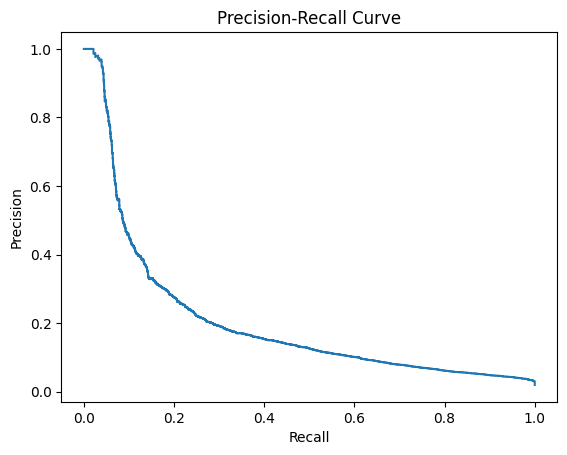

['xgb_4.pkl']

In [68]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_4.pkl")


#### Feature Importance using Model 2

Model 2 gives better top-K precision, which reflects stronger signal in its features -- understand what drives confident return predictions

In [48]:
model_2 = joblib.load("xgb_2.pkl")

# Initialize the TreeExplainer
explainer = shap.Explainer(model_2)

# Compute SHAP values
shap_values = explainer(X_train)

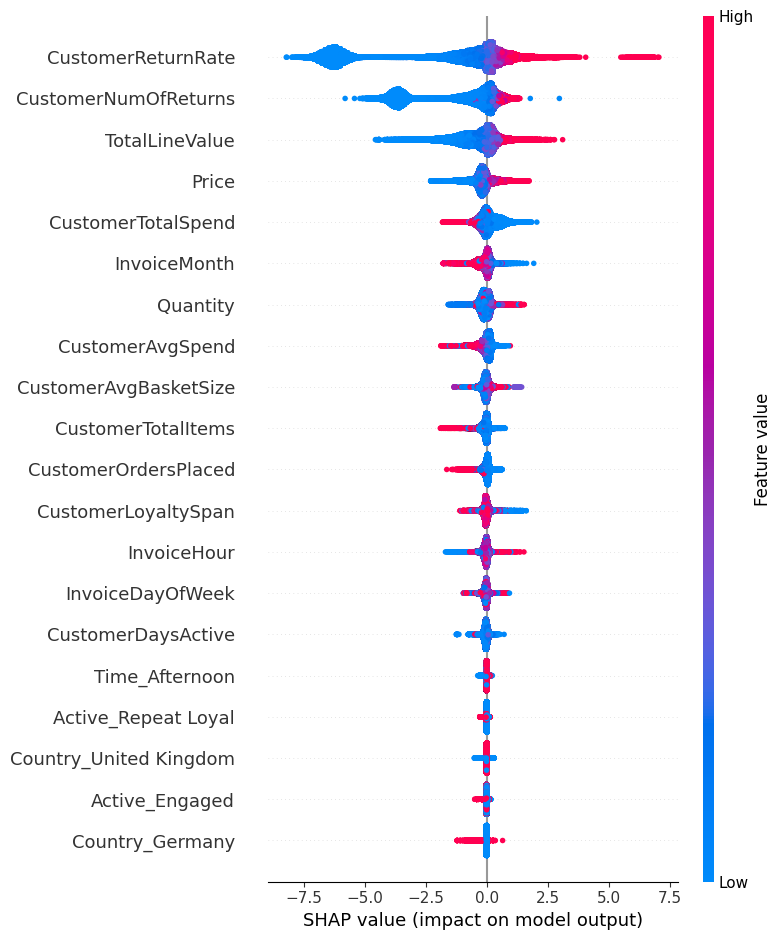

In [49]:
# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train)

A SHAP value shows how much a feature pushes a prediction higher or lower (toward predicting a return or not).
- Values to the right (positive) increase the model’s predicted probability of a return.
- Values to the left (negative) lower the probability of a return.

CustomerReturnRate is the most important feature.
- high values = strongly increase return prediction.

CustomerNumOfReturns
- high values = high return prediction
- past returners are more likely to return again.

TotalLineValue & Price
- higher priced items = higher chance of return

CustomerTotalSpend
- lower total spend = higher return prediction
- higher-value customers are less likely to return

InvoiceMonth
- some months are associated with higher return likelihood

CustomerLoyaltySpan / OrdersPlaced / DaysActive
- Longer relationship = less likely to return

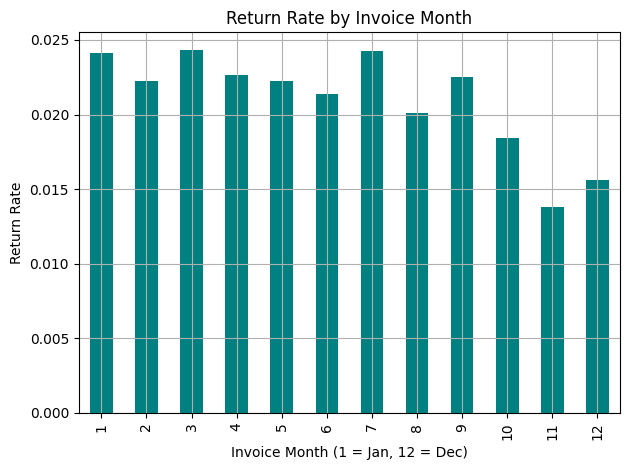

In [50]:
# Assuming you have a DataFrame `df` with 'InvoiceMonth' and 'IsReturn'
return_rate_by_month = df.groupby('InvoiceMonth')['IsReturn'].mean()

# Plot
return_rate_by_month.plot(kind='bar', color='teal')
plt.title('Return Rate by Invoice Month')
plt.xlabel('Invoice Month (1 = Jan, 12 = Dec)')
plt.ylabel('Return Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


Return rates are lower toward the end of the year (Nov–Dec), then spike back in Jan

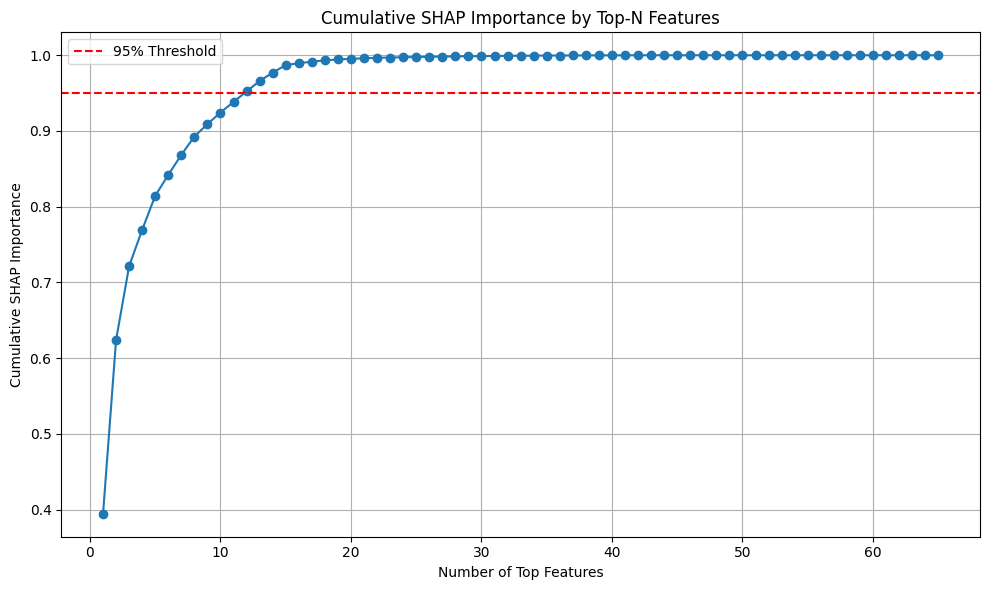

In [51]:
# After computing SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_shap = np.sort(mean_abs_shap)[::-1]
cumulative = np.cumsum(sorted_shap) / np.sum(sorted_shap)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.title("Cumulative SHAP Importance by Top-N Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cumulative SHAP Importance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# Find the cutoff where 95% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.95) + 1
print(f"Top {num_features} features capture 95% of SHAP importance")

Top 12 features capture 95% of SHAP importance


12 features out of 72 

In [100]:
def shap_reduce(id, num_features):
    shap_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    # Get top features
    top_features = shap_importance.head(num_features)['Feature'].tolist()
    print(top_features)

    # Filter training and test sets to top SHAP features
    X_train_reduced = X_train[top_features]
    X_test_reduced = X_test[top_features]

    # Retrain
    xgb_reduced = XGBClassifier(scale_pos_weight=scale_pos_weight,
                                use_label_encoder=False,
                                eval_metric='logloss',
                                random_state=42)
    xgb_reduced.fit(X_train_reduced, y_train)

    y_pred = xgb_reduced.predict(X_test_reduced)
    y_pred_proba = xgb_reduced.predict_proba(X_test_reduced)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

    df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)
    
    joblib.dump((xgb_reduced, top_features), f"xgb_{id}.pkl")

In [101]:
shap_reduce(5, 12)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'InvoiceMonth', 'Quantity', 'CustomerAvgSpend', 'CustomerAvgBasketSize', 'CustomerTotalItems', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.07      0.78      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.79      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8876962947339782
AUC-PR: 0.23571349359491547
Top-5% Precision: 0.0744


In [102]:
# Find the cutoff where 98% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.98) + 1
print(f"Top {num_features} features capture 98% of SHAP importance")

Top 15 features capture 98% of SHAP importance


In [103]:
shap_reduce(6, 15)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'InvoiceMonth', 'Quantity', 'CustomerAvgSpend', 'CustomerAvgBasketSize', 'CustomerTotalItems', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'InvoiceHour', 'InvoiceDayOfWeek', 'CustomerDaysActive']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.79      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.80      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8902493688522262
AUC-PR: 0.24712892584691015
Top-5% Precision: 0.0768


In [69]:
from sklearn.utils import resample
import pandas as pd

# Combine X and y
train_df = X_train.copy()
train_df['target'] = y_train

# Separate majority and minority classes
df_majority = train_df[train_df['target'] == 0]
df_minority = train_df[train_df['target'] == 1]

# Undersample majority class
df_majority_undersampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 3,  # Try 3:1 ratio
    random_state=42
)

# Combine
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle and split back into X and y
X_train_under = df_undersampled.drop(columns='target')
y_train_under = df_undersampled['target']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.92      0.95    157907
           1       0.13      0.58      0.21      3217

    accuracy                           0.91    161124
   macro avg       0.56      0.75      0.58    161124
weighted avg       0.97      0.91      0.94    161124

AUC-ROC: 0.8900981523302084
AUC-PR: 0.22227453834329305
Top-5% Precision: 0.1321


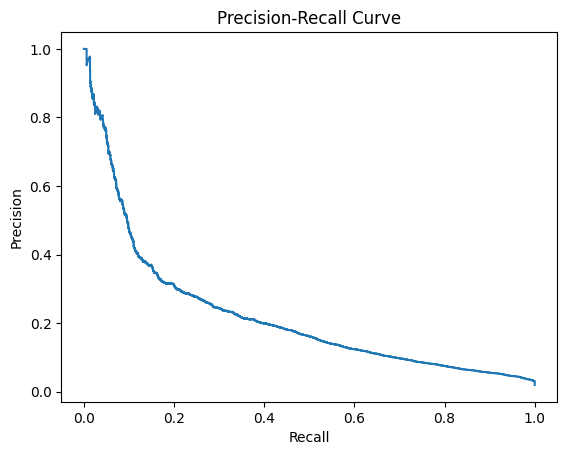

['xgb_7.pkl']

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_under, y_train_under)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_7.pkl")


In [74]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight_under = (y_train_under == 0).sum() / (y_train_under == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight_under:.2f}")

scale_pos_weight: 3.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:16:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.79      0.88    157907
           1       0.07      0.80      0.13      3217

    accuracy                           0.79    161124
   macro avg       0.53      0.80      0.51    161124
weighted avg       0.98      0.79      0.87    161124

AUC-ROC: 0.8886811332795626
AUC-PR: 0.21986286851220732
Top-5% Precision: 0.0700


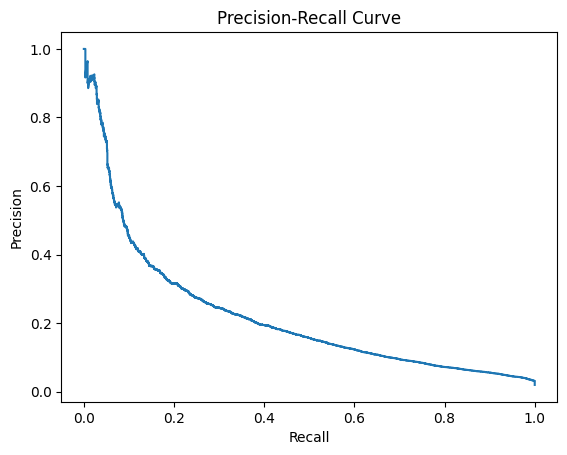

['xgb_8.pkl']

In [75]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_under,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_under, y_train_under)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_8.pkl")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:18:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.87      0.93    157907
           1       0.10      0.68      0.17      3217

    accuracy                           0.87    161124
   macro avg       0.54      0.78      0.55    161124
weighted avg       0.97      0.87      0.91    161124

AUC-ROC: 0.8852405282586674
AUC-PR: 0.21303880509961906
Top-5% Precision: 0.0988


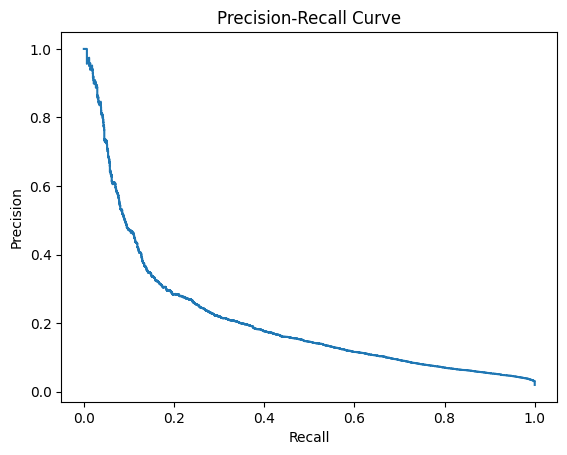

['xgb_9.pkl']

In [76]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_under, y_train_under)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_9.pkl")

In [106]:
xgb_model, top_features = load("xgb_5.pkl")
top_features

['CustomerReturnRate',
 'CustomerNumOfReturns',
 'TotalLineValue',
 'Price',
 'CustomerTotalSpend',
 'InvoiceMonth',
 'Quantity',
 'CustomerAvgSpend',
 'CustomerAvgBasketSize',
 'CustomerTotalItems',
 'CustomerOrdersPlaced',
 'CustomerLoyaltySpan']

In [107]:
X_test_reduced = X_test[top_features]
y_pred = xgb_model.predict(X_test_reduced)
y_pred_proba = xgb_model.predict_proba(X_test_reduced)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.07      0.78      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.79      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8876962947339782
AUC-PR: 0.23571349359491547
Top-5% Precision: 0.0744


In [110]:
threshold = 0.4
y_pred_custom = (y_pred_proba > threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
df_preds = precision_at_k(y_test, y_pred_custom, k_percent=0.05)

              precision    recall  f1-score   support

           0       1.00      0.73      0.85    157907
           1       0.06      0.86      0.12      3217

    accuracy                           0.74    161124
   macro avg       0.53      0.80      0.48    161124
weighted avg       0.98      0.74      0.83    161124

Top-5% Precision: 0.0608


Go with Model 5 (ID 7) - 12 features modeled after Model 2.
- Good recall - catching most returns
- Decent precision (0.07) — better than random (baseline is 2%)
- Top-5% precision is stronger (0.0744) than threshold = 0.4
- 12 SHAP features — simpler, faster, more interpretable

#### Tune hyperparameters

In [112]:
xgb_model, top_features = joblib.load("xgb_5.pkl")  # ID 7 model
X_train = X_train[top_features]
X_test = X_test[top_features]

In [121]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    cv=skf,  # use stratified folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters found:", random_search.best_params_)
print("Best recall score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src

Best parameters found: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best recall score: 0.8343434343434343


{
    'subsample': 0.8,
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.8
}


In [ ]:
from sklearn.model_selection import cross_val_predict

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    631626
           1       0.07      0.83      0.12     12870

    accuracy                           0.76    644496
   macro avg       0.53      0.80      0.49    644496
weighted avg       0.98      0.76      0.85    644496



In [124]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
    'scale_pos_weight': [30, 40, 50, 60]
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_model_10 = XGBClassifier()

random_search = RandomizedSearchCV(
    estimator=xgb_model_10,
    param_distributions=param_dist,
    n_iter=30,
    scoring='recall',
    cv=skf,  # use stratified folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters found:", random_search.best_params_)
print("Best recall score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.8, 'scale_pos_weight': 60, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best recall score: 0.871017871017871


In [126]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    631626
           1       0.06      0.87      0.11     12870

    accuracy                           0.72    644496
   macro avg       0.53      0.79      0.47    644496
weighted avg       0.98      0.72      0.82    644496



In [ ]:
joblib.dump(random_search.best_estimator_, "xgb_10.pkl")

['xgb_10.pkl']

Grid Search = “Brute force” search.
It tries every combination of parameters you give it and finds the one that gives the best performance.

In [127]:
from sklearn.model_selection import GridSearchCV

xgb_model_11 = XGBClassifier(eval_metric="logloss")

param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [250, 300, 350],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.9, 1.0],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1],
    'scale_pos_weight': [50, 60, 70]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model_11,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best GridSearch Params:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best GridSearch Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 70, 'subsample': 0.8}
Best Recall: 0.8979797979797979


In [ ]:
best_model = grid_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80    631626
           1       0.05      0.90      0.10     12870

    accuracy                           0.67    644496
   macro avg       0.52      0.78      0.45    644496
weighted avg       0.98      0.67      0.79    644496



In [132]:
joblib.dump(grid_search.best_estimator_, "xgb_11.pkl")

['xgb_11.pkl']

In [133]:
import optuna
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 30, 70)
    }

    model = XGBClassifier(**params, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(recall_score))
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best recall:", study.best_value)

[I 2025-03-22 21:27:43,036] A new study created in memory with name: no-name-4f966b03-60be-4481-969b-86f11b34e3a0
[I 2025-03-22 21:27:49,368] Trial 0 finished with value: 0.8919968919968919 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.051530992672719315, 'subsample': 0.7067808107896776, 'colsample_bytree': 0.6327195141992032, 'gamma': 0.09588664406323874, 'min_child_weight': 5, 'scale_pos_weight': 68}. Best is trial 0 with value: 0.8919968919968919.
[I 2025-03-22 21:28:02,757] Trial 1 finished with value: 0.8588189588189588 and parameters: {'n_estimators': 366, 'max_depth': 5, 'learning_rate': 0.022608575340574907, 'subsample': 0.8210782291568348, 'colsample_bytree': 0.8119831600357128, 'gamma': 0.2541236391324857, 'min_child_weight': 4, 'scale_pos_weight': 57}. Best is trial 0 with value: 0.8919968919968919.
[I 2025-03-22 21:28:14,624] Trial 2 finished with value: 0.7581973581973581 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.01

Best hyperparameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.010299526216417424, 'subsample': 0.7887416039181485, 'colsample_bytree': 0.6049693680044275, 'gamma': 0.23986638509728886, 'min_child_weight': 3, 'scale_pos_weight': 70}
Best recall: 0.9264957264957264


In [140]:
best_params = study.best_params

# Build final model with best params
final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit to full training data
final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [21:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6049693680044275, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.23986638509728886, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010299526216417424,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=163, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [144]:
print(classification_report(y_train, y_pred))
joblib.dump((final_model, top_features), "xgb_12.pkl")

              precision    recall  f1-score   support

           0       1.00      0.67      0.80    631626
           1       0.05      0.90      0.10     12870

    accuracy                           0.67    644496
   macro avg       0.52      0.78      0.45    644496
weighted avg       0.98      0.67      0.79    644496



['xgb_12.pkl']

In [148]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

              precision    recall  f1-score   support

           0       1.00      0.62      0.77    157907
           1       0.05      0.93      0.09      3217

    accuracy                           0.63    161124
   macro avg       0.52      0.77      0.43    161124
weighted avg       0.98      0.63      0.75    161124

AUC-ROC: 0.874851111048218
AUC-PR: 0.16455581946089815
Top-5% Precision: 0.0474
